In [1]:
import numpy as np 
import pandas as pd
import os 
import sys
from distutils.dir_util import copy_tree
import subprocess
##########################################################################################################################
# Change paths
sys.path.append(r'C:\Users\User\Desktop\Woodframe Building\ModelAssembling')
sys.path.append(r'C:\Users\User\Desktop\Woodframe Building\PostProcessing')
HOME_DIR = r'C:\Users\User\Desktop\Woodframe Building'
RESULTS_DIR = r'C:\Users\User\Desktop\Woodframe Building\Results'

# Steel section database 
sections = pd.read_csv(r'C:\Users\User\Desktop\Woodframe Building\ModelAssembling\Database.csv',encoding = "ISO-8859-1")
##########################################################################################################################
from BuildingModelClass import BuildingModel
from utils import *
import subprocess
import json
from json import JSONEncoder
import subprocess
import matplotlib.pyplot as plt 
import time
from ResultsSummary import *


## Model Assembling 


In [2]:
# Utility function directory 
UTIL_DIR = os.path.join(HOME_DIR, 'ModelAssembling')
# Base directory is the main directory that models, model inputs and utility directory stores
BASE_DIR = UTIL_DIR.replace("ModelAssembling", "")
# Model directory is where you want to store your model
ModelDirectory = BASE_DIR + '\BuildingModels'
# DB directory is where you store Database.csv (for steel section)
DB_DIR = UTIL_DIR
# Results DIR

POST_DIR = os.path.join(BASE_DIR, 'PostProcessing')
os.chdir(POST_DIR)


# If there is no model directory, create one
if os.path.isdir(ModelDirectory) != True:
    os.chdir(BASE_DIR)
    os.mkdir('BuildingModels')
    
# Read in building name 
# Make sure the building name is consistent with the input folders
os.chdir(UTIL_DIR)
with open('BuildingName.txt', 'r') as f:
    BuildingList = f.read() 
BuildingList = BuildingList.split('\n')

# Generate eigen analysis, pushover analysis and dynamic analysis models for each one in the building list
# Store the results 
for i in range(len(BuildingList)):
    InfoDirectory = BASE_DIR + '\BuildingInfo\%s'%BuildingList[i]
    ModelClass = BuildingModel(BuildingList[i], InfoDirectory)

    # alternatively, one can choose to read inputs from json 
    ModelClass.read_in_txt_inputs(BuildingList[i], InfoDirectory, sections)

    if os.path.isdir(ModelDirectory+'\%s'%BuildingList[i]) != True:
        os.chdir(ModelDirectory)
        os.mkdir('%s'%BuildingList[i])
        
    os.chdir(ModelDirectory+'/%s'%BuildingList[i])
    period = generateModalAnalysisModel(ModelClass.ID, ModelClass, BASE_DIR, DB_DIR)
    # Turn off RunPushoverSwitch to speed up the model creation 
    generatePushoverAnalysisModel(ModelClass.ID, ModelClass, BASE_DIR, DB_DIR,
                            GenerateModelSwitch = True, RunPushoverSwitch = True)
    generateDynamicAnalysisModel(ModelClass.ID, ModelClass, BASE_DIR, DB_DIR, period,
                            GenerateModelSwitch = True)

    # post processing and store the results 
    post = AnalysisResults(BuildingID = BuildingList[i], ProjectDirectory = BASE_DIR)
    post.ExtractBuildingInfo()
    post.ExtractPeriod()
    post.ExtractPushover()
    if not os.path.isdir(os.path.join(RESULTS_DIR, BuildingList[i])):
        os.mkdir(os.path.join(RESULTS_DIR, BuildingList[i]))
    post.WriteResults2Json(os.path.join(RESULTS_DIR, BuildingList[i]))
    
    print('Fundamental for model %s is %.3f, average peak strength is %.2f%%'%(BuildingList[i], period[0], post.Pushover_Stat['X']['Peak Strength']*50 + post.Pushover_Stat['Z']['Peak Strength']*50))


Fundamental for model 1L-S2-G2-2C-S2-EX is 0.163, average peak strength is 56.97%


## Generate OpenSees IDA files 

In [5]:
for i in range(len(BuildingList)):
    copy_tree(os.path.join(ModelDirectory, BuildingList[i], 'DynamicAnalysis'), os.path.join(BASE_DIR, 'Hoffman', BuildingList[i]))

## Post Processing Pushover Results

Average peak strength of the two direction for 1L-S2-G2-2C-S2-EX is 0.570


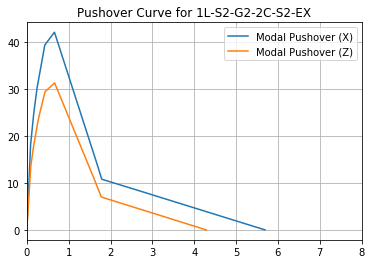

Average peak strength of the two direction for 1L-S2-G2-2C-S2R2-SDSx is 0.963


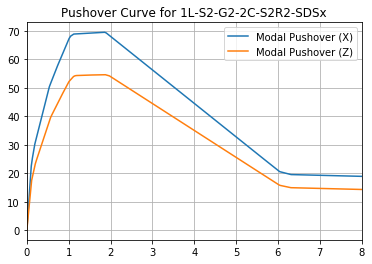

Average peak strength of the two direction for 1H-S2-G2-2C-S2-EX is 0.479


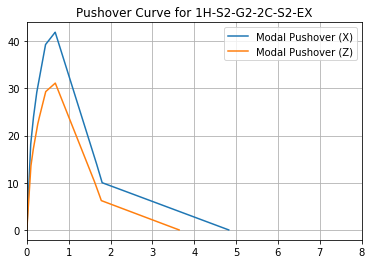

Average peak strength of the two direction for 1H-S2-G2-2C-S2R2-SDSx is 0.782


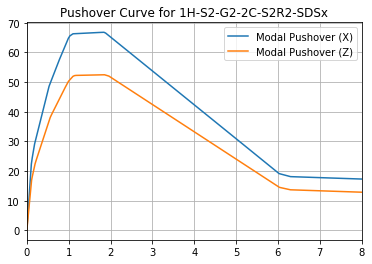

Average peak strength of the two direction for 2L-S2-G2-2C-S2-EX is 0.339


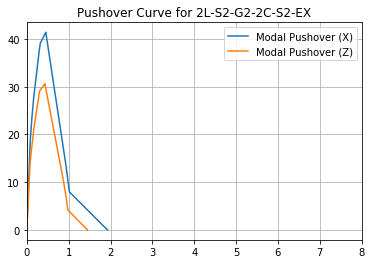

Average peak strength of the two direction for 2L-S2-G2-2C-S2R2-SDSx is 0.523


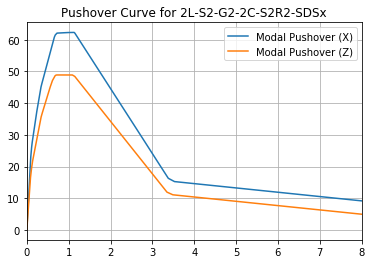

Average peak strength of the two direction for 2H-S2-G2-2C-S2-EX is 0.295


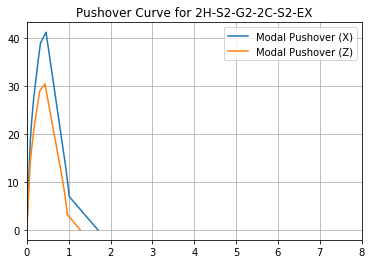

Average peak strength of the two direction for 2H-S2-G2-2C-S2R2-SDSx is 0.453


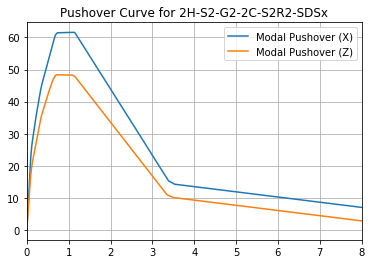

In [47]:
# post process pushover results 
for i in BuildingList:
    post = AnalysisResults(BuildingID = i, ProjectDirectory = BASE_DIR)
    post.ExtractBuildingInfo()
    post.ExtractPushover()
    print('Average peak strength of the two direction for %s is %.3f'%(i, post.Pushover_Stat['X']['Peak Strength']/2 + post.Pushover_Stat['Z']['Peak Strength']/2))
    plt.plot(np.multiply(24+108, post.Pushover_Results['X'][1][-1]),np.dot(post.SeismicWeight, post.Pushover_Results['X'][0]), label = 'Modal Pushover (X)')
    plt.plot(np.multiply(24+108, post.Pushover_Results['Z'][1][-1]),np.dot(post.SeismicWeight, post.Pushover_Results['Z'][0]), label = 'Modal Pushover (Z)')
    # plt.ylim([0,60])
    plt.xlim([0, 8])
    plt.title('Pushover Curve for %s'%i)
    plt.grid()
    plt.legend()
    plt.show()

## Single Scale Single GM Analysis

In [ ]:
Scale_Sa_GM = '0.178 0.274 0.444 0.560 0.652 0.790 0.982 1.246 1.564 2.014 2.417 3.021 3.625 4.028 4.431 5.035'
GM_Num = '45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45'
GM_folder = r'GM_sets/PEER_CEA/SanFrancisco'
Model_Name = '1L-S2-G2-2C-S2-EX'
# for CEA project CHS set, it contains 45 pairs, we use 16 hazard levels for our MSA
GM_ID = 1

acc_time = 0

# Pairing ID == 1
s = time.time()

SetupDyamaicAnalysis(ModelDirectory, Scale_Sa_GM, GM_Num, GM_ID, GM_folder, Model_Name, 1)
os.chdir(r'C:\Users\User\Desktop\PEER CEA Models\Baseline\BuildingModels')
r = os.system('OpenSees RunDynamic_Single.tcl')
f = time.time()


## Incremental Dynamic Analysis 

In [11]:
Scale_Sa_GM = '0.178 0.274 0.444 0.560 0.652 0.790 0.982 1.246 1.564 2.014 2.417 3.021 3.625 4.028 4.431 5.035'
GM_Num = '45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45'
GM_folder = r'GM_sets/PEER_CEA/SanFrancisco'

# for CEA project CHS set, it contains 45 pairs, we use 16 hazard levels for our MSA
start_ID, finish_ID = 1, 721
acc_time = 0

# for Model_Name in BuildingList:
Model_Name = '1L-S2-G2-2C-S2-EX'
s = time.time()
for GM_ID in range(start_ID, finish_ID):

    SetupDyamaicAnalysis(ModelDirectory, Scale_Sa_GM, GM_Num, GM_ID, GM_folder, Model_Name, 1)
    os.chdir(r'C:\Users\User\Desktop\PEER CEA Models\Baseline\BuildingModels')
    r = os.system('OpenSees RunDynamic_Single.tcl')
    f = time.time()
    if not r: 
        print('Hazard Level %i GM Pair %s with Pairing ID %i has finished successfully in %.3fs!'%(int(GM_ID/45)+1, str(GM_ID-(int(GM_ID/45))*45), 1, f-s))
        os.remove('RunDynamic_Single.tcl')
        print('Estimate remaining time %.3fs!'%((f-s)/(GM_ID - start_ID + 1)*(finish_ID - GM_ID)))
    else: 
        print('GM Pair %s has failed'%str(GM_ID))
        break

1 has finished successfully in 7818.743s!
Estimate remaining time 2375.314s!
Hazard Level 13 GM Pair 14 with Pairing ID 1 has finished successfully in 7822.240s!
Estimate remaining time 2357.968s!
Hazard Level 13 GM Pair 15 with Pairing ID 1 has finished successfully in 7827.512s!
Estimate remaining time 2341.202s!
Hazard Level 13 GM Pair 16 with Pairing ID 1 has finished successfully in 7832.294s!
Estimate remaining time 2324.332s!
Hazard Level 13 GM Pair 17 with Pairing ID 1 has finished successfully in 7839.171s!
Estimate remaining time 2308.122s!
Hazard Level 13 GM Pair 18 with Pairing ID 1 has finished successfully in 7840.942s!
Estimate remaining time 2290.454s!
Hazard Level 13 GM Pair 19 with Pairing ID 1 has finished successfully in 7846.653s!
Estimate remaining time 2273.985s!
Hazard Level 13 GM Pair 20 with Pairing ID 1 has finished successfully in 7847.996s!
Estimate remaining time 2256.299s!
Hazard Level 13 GM Pair 21 with Pairing ID 1 has finished successfully in 7851.933s

## Post Processing Dynamic Analysis Results 

In [3]:
ProjectName = 'Baseline'
HazardLevel = np.array([0.178, 0.274, 0.444, 0.560, 0.652, 0.790, 0.982, 1.246, 1.564, 2.014, 2.417, 3.021, 3.625, 4.028, 4.431, 5.035])
NumGM = np.array([45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45])
CollapseCriteria = 0.2
DemolitionCriteria = 0.01

# for ID in BuildingList:
ID = '1L-S2-G2-2C-S2-EX'
# Extract Pushover
post = AnalysisResults(BuildingID = ID, ProjectDirectory = BASE_DIR)
post.ExtractBuildingInfo()
post.ExtractPushover()

# Number of Stories
NumStory = int(post.NumStory)

# Directory info
DynamicDirectory = BASE_DIR + '\BuildingModels\\' + ID + '\DynamicAnalysis\\'
# EigenDirectory = BaseDirectory + ID + '/OpenSees3DModels/EigenValueAnalysis/'
GMDirectory = BASE_DIR + '\BuildingModels\\GM_sets\\PEER_CEA\\SanFrancisco'

# Post-processing
SDR = ExtractSDR (DynamicDirectory, HazardLevel, NumGM, NumStory)
RDR = ExtractRDR (DynamicDirectory, HazardLevel, NumGM, NumStory)
PGA = ExtractPGA (GMDirectory, HazardLevel, NumGM)
PFA = ExtractPFA (DynamicDirectory, HazardLevel, NumGM, NumStory, PGA, g = 386.4)
CollapseCount = pd.DataFrame(Count(SDR, CollapseCriteria, NumGM))
CollapseFragility = pd.DataFrame(lognormfit(HazardLevel, Count(SDR, CollapseCriteria, NumGM), NumGM, 'MLE'))
# DemolitionFragility = pd.DataFrame(lognormfit(HazardLevel, Count(RDR, DemolitionCriteria, NumGM), NumGM, 'MLE'))

if os.path.isdir(BASE_DIR+'\Results\%s'%ID) != True:
    os.chdir(BASE_DIR+'\Results')
    os.mkdir('%s'%ID)

os.chdir(BASE_DIR+'\Results\%s'%ID)
post.WriteResults2Json(ResultsFolder = BASE_DIR+'\Results\%s'%ID)
SDR.to_csv('SDR.csv')
# RDR.to_csv('RDR.csv')
PFA.to_csv('PFA.csv')
CollapseFragility.to_csv('CollapseFragility.csv')




Optimization terminated successfully.
         Current function value: 12.870445
         Iterations: 42
         Function evaluations: 81


## Loss Assessment

In [5]:
HazardLevel = np.array([0.178, 0.274, 0.444, 0.560, 0.652, 0.790, 0.982, 1.246, 1.564, 2.014, 2.417, 3.021, 3.625, 4.028, 4.431, 5.035])
RETURN_PERIOD = [15, 25, 50, 75, 100, 150, 250, 500, 1000, 2500, 2700, 3000, 3300, 3500, 3700, 4000]
RATE = [1/i for i in RETURN_PERIOD]
HazardData_df = pd.DataFrame(data = [HazardLevel, RATE]).T

for ID in BuildingList:
# for ID in [BuildingList[0]]:
    # Extract Pushover
    post = AnalysisResults(BuildingID = ID, ProjectDirectory = BASE_DIR)
    post.ExtractBuildingInfo()
    post.ExtractPushover()

    # Number of Stories
    NumStory = int(post.NumStory)
    BuildingValue = 200 * 30 * 40 * (NumStory - 1)

    os.chdir(BASE_DIR+'\Results\%s'%ID)
    SDR = pd.read_csv('SDR.csv', index_col = 0)
    SDR.columns = SDR.columns.map(int)
    PFA = pd.read_csv('PFA.csv', index_col = 0)
    PFA.columns = PFA.columns.map(int)
    RDR = pd.read_csv('RDR.csv', index_col = 0)
    RDR.columns = RDR.columns.map(int)
    ComponentList = pd.read_csv('ComponentList.csv')
    theta_collapse = pd.read_csv("CollapseFragility.csv", index_col = 0).values.T[0]
    beta = np.array([0.35,0]).reshape([2,1])
    theta_collapse[1] = np.sqrt(theta_collapse[1]**2 + 0.35**2)
    Loss = performLossAssessment(ComponentList, NumStory, 0.2, SDR, PFA, RDR, theta_collapse, HazardData_df, BuildingValue, beta, 3000, 'false')
    Loss.to_csv('Loss.csv')

    Loss = pd.read_csv('Loss.csv', index_col=0)

    EAL = ExpectedAnnulLoss(CLoss = Loss['CollapseLoss'].values.tolist()[0:10],
    DLoss = Loss['DemolitionLoss'].values.tolist()[0:10],
    ComLoss = Loss['ComponentLoss'].values.tolist()[0:10],
    HazardData = HazardData_df.iloc[0:10,:])

    print('The %s case is finished with EAL %.4f%%'%(ID, EAL[0]*100))


The 1L-S2-G2-2C-S2-EX case is finished with EAL 0.4584%
The 1L-S2-G2-2C-S2R2-SDSx case is finished with EAL 0.1246%
The 1H-S2-G2-2C-S2-EX case is finished with EAL 0.7396%
The 1H-S2-G2-2C-S2R2-SDSx case is finished with EAL 0.2153%
The 2L-S2-G2-2C-S2-EX case is finished with EAL 1.1415%
The 2L-S2-G2-2C-S2R2-SDSx case is finished with EAL 0.2980%
The 2H-S2-G2-2C-S2-EX case is finished with EAL 1.5058%
The 2H-S2-G2-2C-S2R2-SDSx case is finished with EAL 0.4119%
